In [5]:
import jax.numpy as jnp
import jax
import genjax
from model import *
from genjax import gen
from genjax import ChoiceMapBuilder as C

from IPython.display import HTML
genjax.pretty()

In [2]:

key = jax.random.PRNGKey(10)
key, subkey = jax.random.split(key)
max_fireflies = jnp.arange(1, 10)
scene_size = 64
steps = jnp.arange(10)

multi_model_jit = jax.jit(multifirefly_model.importance)
chm = C["n_fireflies"].set(6)
tr, weights = multi_model_jit(subkey, chm, (max_fireflies, 2.,))

key, subkey = jax.random.split(key)
tr, weights = multi_model_jit(subkey, chm, (max_fireflies, 2.,))
chm = tr.get_sample()

print("Generating animation")
frames = get_frames(chm)
ani = animate(frames, 20)
#print("Saving animation...")
# ani.save("firefly_simulation_maxglowsize_2.gif", writer="imagemagick", fps=20)
HTML(ani.to_jshtml())

ValueError: not enough values to unpack (expected at least 1, got 0)

In [ ]:

def importance_sample_test():
    test_obs = jnp.ones((100, 64, 64))
    chm = C["observations", "pixels"].set(chm["observations", "pixels"])
    print(chm)

    key, subkey = jax.random.split(key)
    tr, _ = multifirefly_model.importance(subkey, chm, (scene_size, max_fireflies,))
    print(tr.get_score())

In [12]:
@gen 
def init(x_std):
    x = genjax.normal(0, x_std) @ "x_init"
    return x

@gen
def model(t, x_prev, v_std=10., w_std=1.):
    x_init = init(2)
    print(x_init)
    x = .5 * x_prev + 25 * (x_prev / (1 + x_prev ** 2)) + 8 * jnp.cos(1.2 * t) + genjax.normal(0., v_std) @ "x"
    y = x ** 2 / 20 + genjax.normal(0., w_std) @ "y"
    return x, y


In [7]:
def new(key):
    return jax.random.split(key)[1]

In [49]:
def scan_fn(x, _):
    x = x + 1
    y = x * 2
    return x, y

x_final, ys = jax.lax.scan(scan_fn, 0, jnp.arange(0, 100, 2))

In [133]:
@gen 
def mask_test(x):
    y = genjax.normal(x, .1) @ "y"
    return y

key = jax.random.PRNGKey(10)
key, subkeys = jax.random.split(key)
print(subkeys.shape)

masks = jnp.array([True, True, False])
vals = jnp.arange(3.)
print(vals.shape)
print(masks.shape)


mask_tr = genjax.MaskCombinator(mask_test).simulate(subkeys, (masks, vals,))
mask_tr.get_sample()["y"]

(2,)
(3,)
(3,)


Mask(...)

In [135]:
subkeys = jax.random.split(key, 3)
mask_tr = jax.vmap(mask_test.mask().simulate, in_axes=(0, 0))(subkeys, (masks, vals,))
mask_tr.get_sample()["y"]

Mask(...)

In [3]:
bearing = lambda x, y : jnp.atan2(y,x)
measurement_noise = 0.005
velocity_std = 1e-3

def mstep_dimap_pre(state, flag):
   return flag, state, None

def mstep_dimap_post(args, masked_retval):
   return masked_retval.value

def masked_scan_combinator(step, **scan_kwargs):
   
   mstep = step.mask().dimap(
      pre=mstep_dimap_pre,
      post=mstep_dimap_post
   )
 
   return mstep.scan(**scan_kwargs)

@gen
def model(T_arr):
    max_T = T_arr.shape[0]
    T = jnp.sum(T_arr)
    x0 = genjax.normal(0.01,0.01) @ 'x0'
    y0 = genjax.normal(0.95,0.01) @ 'y0'
    vx0 = genjax.normal(0.002,0.01) @ 'vx0'
    vy0 = genjax.normal(-0.013,0.01) @ 'vy0'
    z0 = genjax.normal(bearing(x0,y0), measurement_noise) @ 'z0'
    _, masked_retval = masked_scan_combinator(step, n = max_T)((x0,y0,vx0,vy0), jnp.arange(max_T) < T) @ 'step'
    return masked_retval

@gen
def step(carry, _):
    x, y, vx, vy = carry
    new_vx = genjax.normal(vx, velocity_std) @ 'vx'
    new_vy = genjax.normal(vy, velocity_std) @ 'vy'
    new_x = x + new_vx
    new_y = y + new_vy 
    z = genjax.normal(bearing(new_x, new_y), measurement_noise) @ 'z'
    return (new_x, new_y, new_vx, new_vy), (new_x, new_y, z)

model_importance = jax.jit(model.importance)



In [4]:
tr = model.simulate(jax.random.PRNGKey(10), (jnp.array([10, 20, 30]),))

In [5]:
tr

StaticTrace(...)

In [35]:
# test return value for vmapped mask value inside a gen function

@gen 
def init_vals():
    x = genjax.normal(0., .1) @ "x"
    y = genjax.normal(0., .1) @ "y"
    return {"x": x, "y": y}

@gen
def map_vals():
    vals = jnp.array([1., 2., 3.])
    masks = jnp.array([True, False, True,])
    vals_out = init_vals.mask().vmap(in_axes=(0))(masks) @ "vals"
    return vals_out

tr = map_vals.simulate(jax.random.PRNGKey(10), ())


In [32]:
from maskcombinator_model import multifirefly_model
from maskcombinator_model import get_frames, animate

key = jax.random.PRNGKey(3124)
key, subkey = jax.random.split(key)
max_fireflies = jnp.arange(1, 5)

vec_chm = jax.vmap(lambda idx, v: C["steps", idx, "observations", "pixels"].set(v))(jnp.arange(100), jnp.ones((100, 64, 64)))

multi_model_jit = jax.jit(multifirefly_model.importance)
print(vec_chm)
tr, weight = multi_model_jit(subkey, vec_chm, (max_fireflies,))

# key, subkey = jax.random.split(key)
# tr = multi_model_jit(subkey,(max_fireflies,))

chm = tr.get_sample()
print(chm)

StaticChm(addr='steps', c=IdxChm(addr=<jax.Array int32(100,) [≥0, ≤99] zero:1 nonzero:99>, c=StaticChm(addr='observations', c=StaticChm(addr='pixels', c=ValueChm(v=<jax.Array float32(100, 64, 64)>)))))
Mask(flag=<jax.Array([ True,  True,  True,  True], dtype=bool)>, value={'blink_rate': <jax.Array([0.09207574, 0.09310818, 0.11547124, 0.09398933], dtype=float32)>, 'blinking': <jax.Array([0, 0, 0, 0], dtype=int32)>, 'state_duration': <jax.Array([0, 0, 0, 0], dtype=int32)>, 'vx': <jax.Array([-9.2645609e-01,  9.4993007e-01, -2.5099120e-04, -2.9223177e-01],      dtype=float32)>, 'vy': <jax.Array([-0.12066527,  0.68142754, -0.78287894,  0.7474441 ], dtype=float32)>, 'x': <jax.Array([11.299972, 16.064215, 50.99797 , 33.872276], dtype=float32)>, 'y': <jax.Array([ 7.9636464, 41.6382   , 62.391663 , 44.23269  ], dtype=float32)>})
XorChm(c1=XorChm(c1=StaticChm(addr='n_fireflies', c=ValueChm(v=<jax.Array(4, dtype=int32)>)), c2=StaticChm(addr='init', c=IdxChm(addr=<jax.Array([0, 1, 2, 3], dtype=int

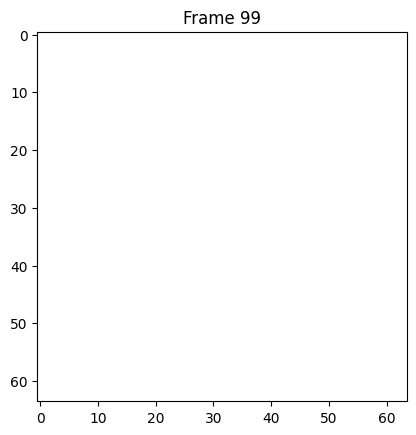

In [34]:
anim = animate(list(chm["steps", ..., "observations", "pixels"].value), 20)
HTML(anim.to_jshtml())

In [26]:
print(weight)

-1.3862944


In [16]:
from genjax import ChoiceMapBuilder as C
vec_chm = jax.vmap(lambda idx, v: C["steps", idx, "observations", "pixels"].set(v))(jnp.arange(10), jnp.zeros((10, 64, 64)))
vec_chm["steps", 10, "observations", "pixels"]

(64, 64)

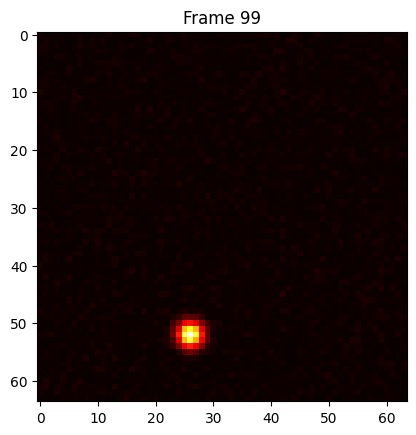

In [9]:
from IPython.display import HTML
pixels = chm["steps", ..., "observations", "pixels"].value
frames = list(pixels)
anim = animate(frames, 20)
HTML(anim.to_jshtml())

In [2]:
import genjax
import jax
import jax.numpy as jnp


@genjax.gen
def init(): 
  x = genjax.normal(0., 1.) @ "x"
  return x

@genjax.gen
def model_1():
    masks = jnp.array([True, False, True])
    vmask_init = jax.vmap(init.mask(), in_axes=(0,))(masks) @ "init"
    return vmask_init

@genjax.gen
def model_2():
   masks = jnp.array([True, False, True])
   vmask_init = init.mask().vmap(in_axes=(0,))(masks,) @ "init"
   return vmask_init

key = jax.random.PRNGKey(10)
# tr1 = model_1.simulate(key, ())
tr2 = model_2.simulate(key, ())

try:
    print(tr1.get_sample())
except Exception as e:
    print(e)

try:
    print(tr2.get_sample())
except Exception as e:
    print(e)


name 'tr1' is not defined
StaticChm(addr='init', c=IdxChm(addr=<jax.Array([0, 1, 2], dtype=int32)>, c=MaskChm(flag=<numpy.array([ True, False,  True])>, c=StaticChm(addr='x', c=ValueChm(v=<jax.Array([0.00570117, 1.0804315 , 0.33788422], dtype=float32)>)))))


In [3]:
genjax.pretty()

In [4]:
tr1.get_sample()

StaticChm(...)

In [73]:
try:
    print(tr1.get_sample())
except Exception as e:
    print(e)

try:
    print(tr2.get_sample())
except Exception as e:
    print(e)


Function genjax._src.core.generative.choice_map.choice_map_masked() parameter flag="array([ True, False,  True])" violates type hint bool | jaxtyping.Bool[Array, '...'], as <class "numpy.ndarray"> "array([ True, False,  True])" not <class "jaxtyping.Bool[Array, '...']"> or bool.
StaticChm(...)


In [76]:
tr2.get_sample()

StaticChm(...)